# Imports

In [2]:
import torch
import wandb
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F

## Weights and Biases Login
Logging all model runs on weights and biases dashboard

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ibrahimalghafri (ibrahimalghafri-rihal). Use `wandb login --relogin` to force relogin


True

# 1. Preprocessing

### 1.1 Loading Dataset and Dataloaders

In [3]:
# Define the data transformations (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((28, 28)),    # Resize images to 128x128
    transforms.ToTensor(),            # Convert images to tensor
    transforms.Normalize((0.5), (0.5))  # Normalize the images
])

# Load the datasets
test_dataset = datasets.ImageFolder(root='archive-4/test', transform=transform)
train_dataset = datasets.ImageFolder(root='archive-4/train', transform=transform)

# Create DataLoader objects for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Example: Print some batch information
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Batch size: {images.size(0)}")
print(f"Labels: {labels}")


Batch size: 16
Labels: tensor([0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0])


### 1.2 Visualising sample images after preprocessing

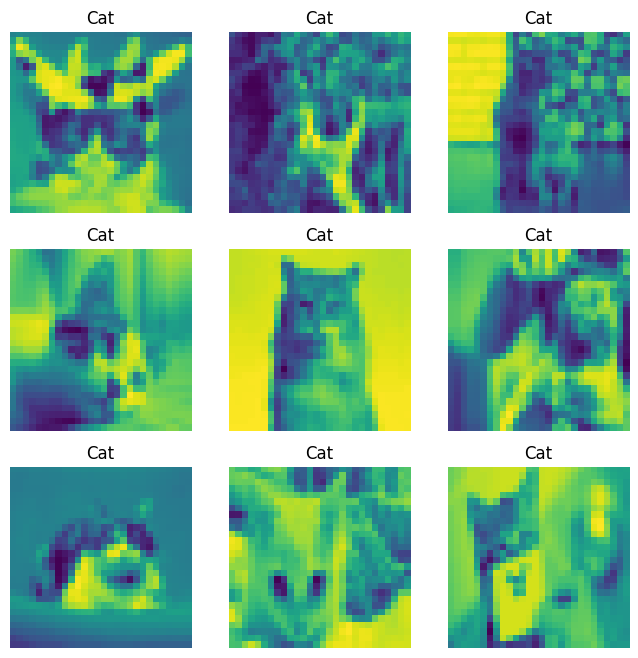

In [4]:
labels_map = {
    0: "Cat",
    1: "Dog",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    
    # Permute the image tensor from (C, H, W) to (H, W, C)
    img = img.permute(1, 2, 0)  # Move channels to last dimension
    
    # If the image was normalized, undo the normalization for display
    img = img * 0.5 + 0.5  # Assuming normalization was done with mean=0.5, std=0.5
    
    plt.imshow(img)  # Now img is in the correct format
plt.show()


In [5]:
### 2.1 Visualising sample images after preprocessing

# 2. Neural Network Model

### 2.1 Visualising sample images after preprocessing

In [6]:
# Setting computation device

device = "cpu"

# (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )

print(f"Using {device} device")

Using mps device


In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()    # base
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),    # base: First dense layer mapping the flattened inputs into a 512 dimensional feature space
            nn.ReLU(),    #base: applies non-linearity to understand complex patterns
            nn.Linear(512, 512),    # base: Second dense layer further refines extracted feature
            nn.ReLU(),    # base:
            nn.Linear(512, 10)   # head: maps the 512- dimensional features extracted by the base into 10 output values (logits_)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model) 

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")


Image batch shape: torch.Size([16, 1, 28, 28])
Label batch shape: torch.Size([16])


In [9]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax (dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([8], device='mps:0')


In [10]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0345,  0.0257,  0.0180,  ..., -0.0273, -0.0111, -0.0341],
        [-0.0319,  0.0203,  0.0346,  ...,  0.0302, -0.0324,  0.0036]],
       device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0219, -0.0044], device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0176, -0.0072, -0.0158,  ..., -0.0164,  0.0395,  0.0201],
        [ 0.0336,  0.0249,  0.0158,  ...,  0.0107, -0.0202, -0.0096]],
       device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Size: torch.Size([512]) | Values : tensor([-0.0381, -0.0035], device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.4.weight | Size: torch.Size([10, 512]) | Values : tensor([[-0.0100,  0.0169, -0.0329,  ...,  0.0228,  0.0136,  0.0100],
        [ 0.0409, -0.0165, -0.0154,  ..

### Model summary

In [11]:
# from torchinfo import summary

# summary(model,input_size=(16, 1, 28, 28)) 

### Adjusting hyperparameters

In [12]:
# choosing learning rate
learning_rate = 1e-3

# selecting batch size
batch_size = 16

# selecting number of epoches
epochs = 150

### Loss function and Optimizer

In [13]:
# Initialise the loss function
loss_fn = nn.CrossEntropyLoss()

# Initialise the optimizer by registering the model's parameters that need to be trained
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train and test loops

In [10]:


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    # setting the model to training mode
    model.train()
    total_train_loss = 0
    
    for batch, (X, y) in enumerate (dataloader):
        X, y = X.to(device), y.to(device)
        
        # computing prediction and loss
        pred = model(X)
        train_loss = loss_fn(pred, y)
        
        # backpropogation
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_train_loss += train_loss.item()
        
        #if batch == len(train_loader) - 1 or batch % 1 == 0:
        train_loss = train_loss.item()
        current = (batch + 1) * batch_size
        print(f"loss: {train_loss:>7f} [{current:>5d}/{size:>5d}]")
     
    avg_loss = total_train_loss / len(train_loader)
    print(f"Average loss for epoch: {avg_loss:>7f}")
    
    return avg_loss
            

def test_loop(dataloader, model, loss_fn):
    
    # set the model to evaluation mode
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    # evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    accuracy = 100 * correct
    print(f"\n Test Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, accuracy



### Early stop function

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001):
        
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
   

## Training Neural Network and Evaluation

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

training_losses = []
validation_losses = []

wandb.init(project="cats-and-dogs-classification-project", name="NeuralNetwork_Run",
          
    config={
    "learning_rate": 0.02,
    "architecture": "NeuralNetwork",
    "dataset": "CatsandDogsDataset",
    "epochs": 150,

})

for t in range (epochs):
    print(f"Epoch {t+1}\n---------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    #test_loop(test_loader, model, loss_fn)
    val_loss, val_accuracy = test_loop(test_loader, model, loss_fn)
    
    # Store losses
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    
    # log metrics to WandB
    
    wandb.log({"epoch": epochs,
              "train_loss": train_loss,
              "val_loss":val_loss,
               "val_accuracy":val_accuracy})
    
    # Early stop check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stop triggered")
        break

        
wandb.finish()
print("Training completed.")
print("Done!")

Epoch 1
---------------------
loss: 2.281417 [   16/  557]
loss: 2.297866 [   32/  557]
loss: 2.299458 [   48/  557]
loss: 2.294776 [   64/  557]
loss: 2.296324 [   80/  557]
loss: 2.284154 [   96/  557]
loss: 2.282647 [  112/  557]
loss: 2.283947 [  128/  557]
loss: 2.283473 [  144/  557]
loss: 2.293084 [  160/  557]
loss: 2.276484 [  176/  557]
loss: 2.270161 [  192/  557]
loss: 2.276999 [  208/  557]
loss: 2.273185 [  224/  557]
loss: 2.262154 [  240/  557]
loss: 2.265741 [  256/  557]
loss: 2.275132 [  272/  557]
loss: 2.273524 [  288/  557]
loss: 2.252008 [  304/  557]
loss: 2.263388 [  320/  557]
loss: 2.257561 [  336/  557]
loss: 2.247035 [  352/  557]
loss: 2.270446 [  368/  557]
loss: 2.255936 [  384/  557]
loss: 2.247311 [  400/  557]
loss: 2.223877 [  416/  557]
loss: 2.240037 [  432/  557]
loss: 2.273211 [  448/  557]
loss: 2.230017 [  464/  557]
loss: 2.233989 [  480/  557]
loss: 2.227103 [  496/  557]
loss: 2.238496 [  512/  557]
loss: 2.240080 [  528/  557]
loss: 2.24493

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▅▇██▆▆▇▃▅▇▅▅▇▆▆▅▆▄▅▅▆▄▅▄▅▄▃▃▄▄▅▆▄▆▅▄▄
val_loss,██▇▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,150
train_loss,0.65669
val_accuracy,50
val_loss,0.72696


Training completed.
Done!


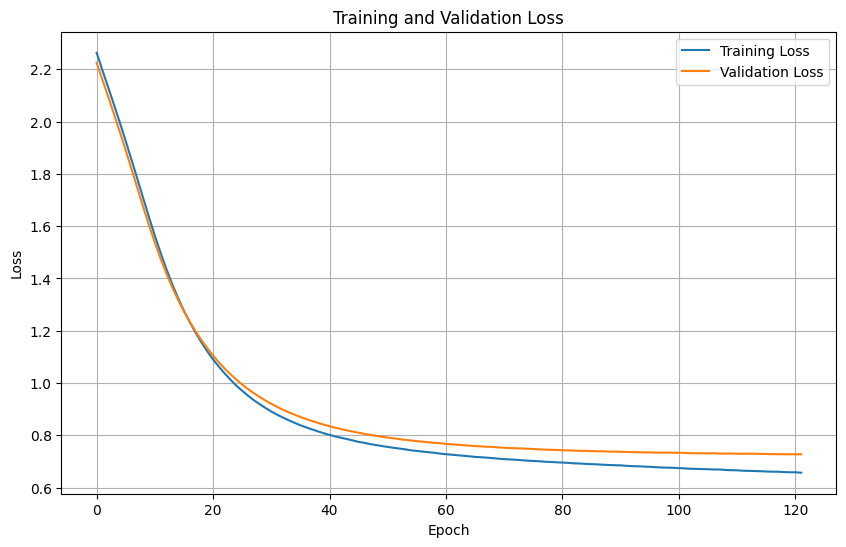

In [17]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


# 3. Pre-trained VGG16 Model

### 3.1 Loading and preprocessing dataset

In [18]:
from torchvision import transforms

# Pre-processing the images for VGG16
transform2 = transforms.Compose([
    transforms.Resize((224, 224)),          # resizing to 224x224 as per required for VGG16
    transforms.Grayscale(num_output_channels=3),  # converting grayscale to RGB (3 channels)
    transforms.ToTensor(),                 # converting images to pytorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # normalize as per ImageNet
                         std=[0.229, 0.224, 0.225])
])

# Load the datasets
test_dataset2 = datasets.ImageFolder(root='archive-4/test', transform=transform2)
train_dataset2 = datasets.ImageFolder(root='archive-4/train', transform=transform2)

# Create DataLoader objects for batching
train_loader2 = DataLoader(train_dataset2, batch_size=16, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=16, shuffle=False)

# Print some batch information
data_iter2 = iter(train_loader2)
images2, labels2 = next(data_iter2)
print(f"Batch size: {images.size(0)}")
print(f"Labels: {labels2}")

Batch size: 16
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1])


### 3.2 Building the pre-trained model

In [19]:
from torchvision import models
from torch import nn

# loading pretrained model VGG16
vgg16 = models.vgg16(pretrained=True)

# freeze the feature extractor layer
for paramedics in vgg16.features.parameters():
    param.requires_grad = False
    

# modifying the classifier to match the dataset (two classes)
num_classes = len(train_dataset.classes)
vgg16.classifier[6] = nn.Linear(4096, num_classes)

# moving the model to the device
vgg16 = vgg16.to(device)




# # finetuning model according to medium
# vgg16.fc = nn.Sequential(
#     nn.Linear(num_classes, 4096),
#     nn.ReLU(inplace = True),
#     nn.Dropout(0.5),
#     nn.Linear(4096, num_classes)
# )


print(vgg16)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 3.3 Training and evaluating the model

In [20]:
from torch import optim

# defining the optimizer
optimizer2 = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

# choosing the loss function
loss_fn2 = nn.CrossEntropyLoss()

# choosing number of epoches
epochs2 = 150

# saving losses for loss line graph
training_losses2 = []
validation_losses2 = []

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)


wandb.init(project="cats-and-dogs-classification-project", name="VGG16_Run",
          
    config={
    "learning_rate": 0.02,
    "architecture": "VGG16",
    "dataset": "CatsandDogsDataset",
    "epochs": 150,

})

# training the model
for epoch in range(epochs2):
    print(f"Epoch {epoch+1}\n{'_'*20}")
    train_loss2 = train_loop(train_loader2, vgg16, loss_fn2, optimizer2)
    test_loss2, val_loss2 = test_loop(test_loader2, vgg16, loss_fn2)
    
    # storing losses
    training_losses2.append(train_loss2)
    validation_losses2.append(test_loss2)
    
    # log metrics to WandB
    
    wandb.log({"epoch2": epochs2,
              "train_loss2": train_loss2,
              "val_loss2":test_loss2,
               "val_accuracy2":val_loss2})
    
    # Early stop check
    early_stopping(val_loss2)
    if early_stopping.early_stop:
        print("Early stop triggered")
        break

        loss_fn = nn.CrossEntropyLoss()
        
wandb.finish()
print("Training completed.")

Epoch 1
____________________
loss: 0.803579 [   16/  557]
loss: 0.746139 [   32/  557]
loss: 0.469280 [   48/  557]
loss: 0.184029 [   64/  557]
loss: 0.283675 [   80/  557]
loss: 0.165459 [   96/  557]
loss: 0.205784 [  112/  557]
loss: 0.119092 [  128/  557]
loss: 0.062165 [  144/  557]
loss: 0.099180 [  160/  557]
loss: 0.251989 [  176/  557]
loss: 0.122539 [  192/  557]
loss: 0.169765 [  208/  557]
loss: 0.143796 [  224/  557]
loss: 0.033043 [  240/  557]
loss: 0.112074 [  256/  557]
loss: 0.125137 [  272/  557]
loss: 0.167171 [  288/  557]
loss: 0.105589 [  304/  557]
loss: 0.009004 [  320/  557]
loss: 0.067242 [  336/  557]
loss: 0.085593 [  352/  557]
loss: 0.291125 [  368/  557]
loss: 0.068163 [  384/  557]
loss: 0.022681 [  400/  557]
loss: 0.229910 [  416/  557]
loss: 0.492005 [  432/  557]
loss: 0.096011 [  448/  557]
loss: 0.141206 [  464/  557]
loss: 0.014483 [  480/  557]
loss: 0.025022 [  496/  557]
loss: 0.051383 [  512/  557]
loss: 0.144226 [  528/  557]
loss: 0.036725

wandb-core(40104) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.024531 [   16/  557]
loss: 0.026730 [   32/  557]
loss: 0.008260 [   48/  557]
loss: 0.099359 [   64/  557]
loss: 0.009762 [   80/  557]
loss: 0.009145 [   96/  557]


wandb-core(40108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.012887 [  112/  557]
loss: 0.019440 [  128/  557]
loss: 0.004423 [  144/  557]
loss: 0.022757 [  160/  557]


wandb-core(40115) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.007270 [  176/  557]
loss: 0.038198 [  192/  557]
loss: 0.003633 [  208/  557]
loss: 0.037571 [  224/  557]
loss: 0.005736 [  240/  557]


wandb-core(40116) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.019674 [  256/  557]
loss: 0.003801 [  272/  557]
loss: 0.008348 [  288/  557]
loss: 0.036066 [  304/  557]


wandb-core(40122) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.015185 [  320/  557]
loss: 0.033202 [  336/  557]
loss: 0.019446 [  352/  557]
loss: 0.024855 [  368/  557]
loss: 0.015939 [  384/  557]


wandb-core(40129) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.001325 [  400/  557]
loss: 0.006185 [  416/  557]
loss: 0.062430 [  432/  557]
loss: 0.005076 [  448/  557]


wandb-core(40137) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.014995 [  464/  557]
loss: 0.036281 [  480/  557]
loss: 0.047721 [  496/  557]
loss: 0.016620 [  512/  557]
loss: 0.027894 [  528/  557]


wandb-core(40141) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.082343 [  544/  557]


wandb-core(40162) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.012094 [  560/  557]
Average loss for epoch: 0.023405


wandb-core(40166) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



 Test Error: 
 Accuracy: 99.3%, Avg loss: 0.050111 

Epoch 5
____________________
loss: 0.002435 [   16/  557]


wandb-core(40175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.001428 [   32/  557]
loss: 0.007680 [   48/  557]
loss: 0.007569 [   64/  557]
loss: 0.004141 [   80/  557]
loss: 0.013975 [   96/  557]


wandb-core(40183) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.046901 [  112/  557]
loss: 0.009439 [  128/  557]
loss: 0.006738 [  144/  557]
loss: 0.013556 [  160/  557]
loss: 0.007576 [  176/  557]
loss: 0.007823 [  192/  557]


wandb-core(40186) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.006751 [  208/  557]
loss: 0.009531 [  224/  557]
loss: 0.030941 [  240/  557]
loss: 0.012418 [  256/  557]
loss: 0.019210 [  272/  557]


wandb-core(40188) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.026239 [  288/  557]
loss: 0.014023 [  304/  557]
loss: 0.040580 [  320/  557]
loss: 0.014843 [  336/  557]
loss: 0.007798 [  352/  557]
loss: 0.001510 [  368/  557]


wandb-core(40195) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.010559 [  384/  557]
loss: 0.020006 [  400/  557]
loss: 0.000994 [  416/  557]
loss: 0.002979 [  432/  557]
loss: 0.005379 [  448/  557]


wandb-core(40203) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.020718 [  464/  557]
loss: 0.105579 [  480/  557]
loss: 0.002267 [  496/  557]
loss: 0.020691 [  512/  557]
loss: 0.066515 [  528/  557]


wandb-core(40211) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.006077 [  544/  557]
loss: 0.001785 [  560/  557]
Average loss for epoch: 0.016476

 Test Error: 
 Accuracy: 97.9%, Avg loss: 0.068342 

Epoch 6
____________________


wandb-core(40222) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.008229 [   16/  557]
loss: 0.015247 [   32/  557]
loss: 0.002003 [   48/  557]
loss: 0.007734 [   64/  557]
loss: 0.010601 [   80/  557]


wandb-core(40224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.029901 [   96/  557]
loss: 0.000821 [  112/  557]
loss: 0.012494 [  128/  557]
loss: 0.001201 [  144/  557]
loss: 0.001002 [  160/  557]


wandb-core(40237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.011983 [  176/  557]
loss: 0.052210 [  192/  557]
loss: 0.017887 [  208/  557]
loss: 0.006342 [  224/  557]


wandb-core(40241) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.054084 [  240/  557]
loss: 0.006690 [  256/  557]
loss: 0.011798 [  272/  557]
loss: 0.051121 [  288/  557]
loss: 0.007013 [  304/  557]


wandb-core(40249) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.002701 [  320/  557]
loss: 0.007918 [  336/  557]
loss: 0.031779 [  352/  557]
loss: 0.013467 [  368/  557]


wandb-core(40257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.007592 [  384/  557]
loss: 0.009549 [  400/  557]
loss: 0.026537 [  416/  557]
loss: 0.005707 [  432/  557]


wandb-core(40265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.013799 [  448/  557]
loss: 0.005651 [  464/  557]
loss: 0.004902 [  480/  557]
loss: 0.004197 [  496/  557]


wandb-core(40270) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.077842 [  512/  557]
loss: 0.009416 [  528/  557]
loss: 0.072397 [  544/  557]
loss: 0.030165 [  560/  557]
Average loss for epoch: 0.018057


wandb-core(40279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



 Test Error: 
 Accuracy: 99.3%, Avg loss: 0.041918 

Early stop triggered


epoch2,▁▁▁▁▁▁
train_loss2,█▂▂▁▁▁
val_accuracy2,▁▄▄█▄█
val_loss2,█▆▄▂▆▁
epoch2,150
train_loss2,0.01806
val_accuracy2,99.28571
val_loss2,0.04192


Training completed.


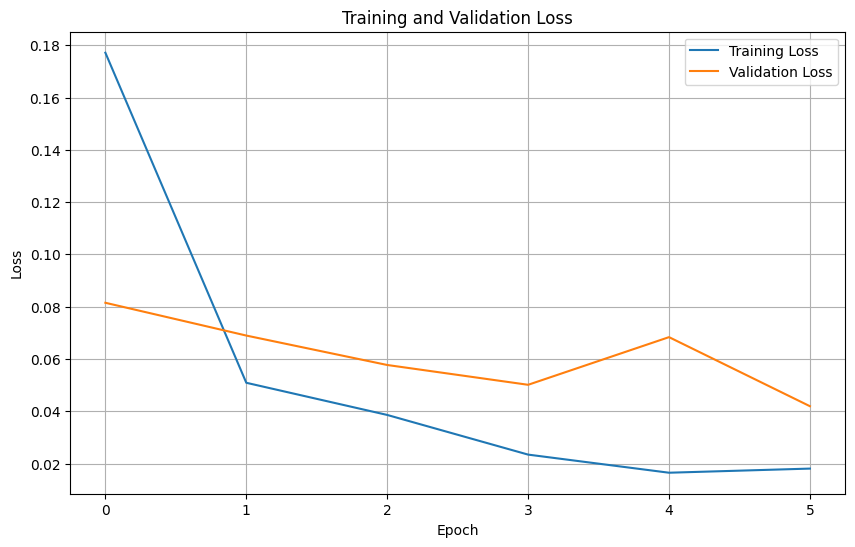

In [21]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_losses2, label='Training Loss')
plt.plot(validation_losses2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [22]:
torch.save(model.state_dict(), "model.pth")
print("Saved Pytorch Model State to model.pth")

Saved Pytorch Model State to model.pth


In [23]:
torch.save(vgg16, "model_complete.pth")

In [24]:
model2 = torch.load("model_complete.pth")

model2.eval()

/var/folders/xj/vg2r648x069cl2jlksmb20rm0000gn/T/ipykernel_39583/2441451470.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2 = torch.load("model_complete.pth")


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 4. Convolutional Neural Network (CNN) Model

### 4.1 Loading and preprocessing

In [25]:
from torchvision import transforms

transform3 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the datasets
test_dataset3 = datasets.ImageFolder(root='archive-4/test', transform=transform3)
train_dataset3 = datasets.ImageFolder(root='archive-4/train', transform=transform3)

# Create DataLoader objects for batching
train_loader3 = DataLoader(train_dataset3, batch_size=16, shuffle=True)
test_loader3 = DataLoader(test_dataset3, batch_size=16, shuffle=False)

### 4.2 Visualising dataset

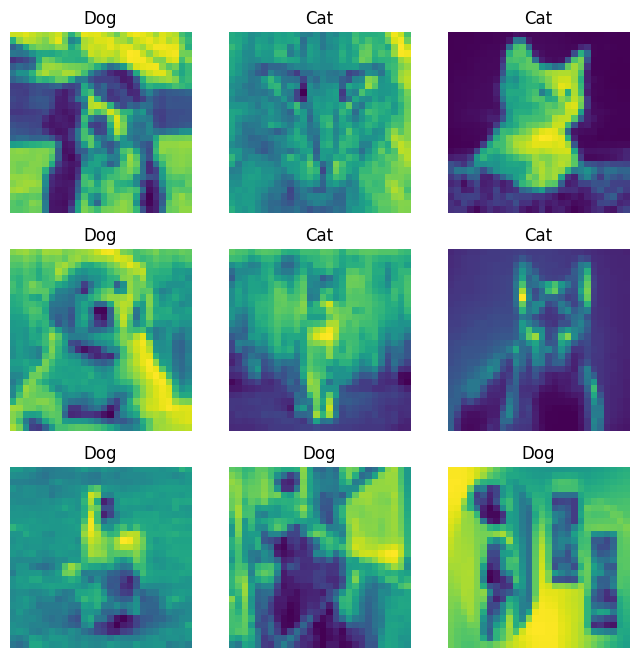

In [26]:
labels_map = {
    0: "Cat",
    1: "Dog",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    
    # Permute the image tensor from (C, H, W) to (H, W, C)
    img = img.permute(1, 2, 0)  # Move channels to last dimension
    
    # If the image was normalized, undo the normalization for display
    img = img * 0.5 + 0.5  # Assuming normalization was done with mean=0.5, std=0.5
    
    plt.imshow(img)  # Now img is in the correct format
plt.show()

### 4.3 Building the Convolutional Neural Network (CNN)

In [27]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        
        # base
        
        # convolutional layers
        
        # self.conv1 extracts 32 feature maps from the RGB input image using a 3×3 filter.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)   
        # batch normalisation - normalisation across the batch dimension
        self.conv2_bn = nn.BatchNorm2d(32)  
        # self.conv2 extracts 64 feature maps from the output of conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 
        # batch normalisation
        self.conv3_bn = nn.BatchNorm2d(64) 
        # reduces feature map dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # randomly dropping units during training, applied in fully connected layers 
        self.dropout = nn.Dropout(0.5)

        # Head
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        
        
    def forward(self, x):
        
        # Convolutional layers with ReLU pooling
        x = F.relu(self.conv1(x))
        x = self.conv2_bn(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.conv3_bn(x)
        x = self.pool(x)
        
        # print("Shape before flattening:", x.shape)  # Debugging step

        # The convolutional output (which is a 3D tensor: batch size, channels, height, width) 
        # is flattened into a 1D tensor so it can be passed to the fully connected layers        
        x = x.view(x.size(0), -1)
        
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(F.relu(x))
        x = self.fc3(x)
        
        return x
    
CNNmodel = ConvolutionalNeuralNetwork().to(device)
print(CNNmodel) 

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [39]:
total_params = sum(p.numel() for p in CNNmodel.parameters())

print(total_params)

25718210


### 4.4 Training and Evaluating CNN Model

In [28]:
import torch.nn.functional as F

model = ConvolutionalNeuralNetwork().to(device)

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

epochs3 = 150

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# saving losses for loss line graph
training_losses3 = []
validation_losses3 = []

wandb.init(project="cats-and-dogs-classification-project", name="CNN_Run",
          
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CatsandDogsDataset",
    "epochs": 150,

})

for t in range (epochs3):
    print(f"Epoch {t+1}\n---------------------")
    train_loss3 = train_loop(train_loader3,model , loss_fn, optimizer)
    #test_loop(test_loader, model, loss_fn)
    test_loss3, val_loss3 = test_loop(test_loader3,model , loss_fn)
    
    training_losses3.append(train_loss3)
    validation_losses3.append(test_loss3)
    
    # log metrics to WandB
    
    wandb.log({"epoch3": epochs,
              "train_loss3": train_loss3,
              "val_loss3":test_loss3,
               "val_accuracy3":val_loss3})
    
    # Early stop check
    early_stopping(val_loss3)
    if early_stopping.early_stop:
        print("Early stop triggered")
        break
        
wandb.finish()
print("Training completed.")       

wandb-core(40287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(40288) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 1
---------------------
loss: 0.744885 [   16/  557]
loss: 0.701191 [   32/  557]
loss: 0.709163 [   48/  557]
loss: 0.656876 [   64/  557]
loss: 0.722008 [   80/  557]
loss: 0.652841 [   96/  557]
loss: 0.917954 [  112/  557]
loss: 0.764933 [  128/  557]
loss: 0.875948 [  144/  557]
loss: 0.761165 [  160/  557]
loss: 0.675898 [  176/  557]
loss: 0.695848 [  192/  557]
loss: 0.687052 [  208/  557]
loss: 0.671790 [  224/  557]


wandb-core(40326) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.858348 [  240/  557]
loss: 0.721813 [  256/  557]
loss: 0.714803 [  272/  557]
loss: 0.690760 [  288/  557]
loss: 0.610397 [  304/  557]
loss: 0.651899 [  320/  557]
loss: 0.707637 [  336/  557]
loss: 0.714866 [  352/  557]
loss: 0.801745 [  368/  557]
loss: 0.673360 [  384/  557]
loss: 0.845059 [  400/  557]
loss: 0.796568 [  416/  557]
loss: 0.683299 [  432/  557]
loss: 0.731943 [  448/  557]
loss: 0.668161 [  464/  557]
loss: 0.725028 [  480/  557]
loss: 0.810639 [  496/  557]
loss: 0.678445 [  512/  557]
loss: 0.736255 [  528/  557]
loss: 0.754805 [  544/  557]


wandb-core(40332) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.792877 [  560/  557]
Average loss for epoch: 0.731607

 Test Error: 
 Accuracy: 51.4%, Avg loss: 0.690688 

Epoch 2
---------------------
loss: 0.705981 [   16/  557]
loss: 0.701287 [   32/  557]
loss: 0.697002 [   48/  557]
loss: 0.765230 [   64/  557]
loss: 0.593937 [   80/  557]
loss: 0.688306 [   96/  557]
loss: 0.649410 [  112/  557]
loss: 0.803258 [  128/  557]
loss: 0.611491 [  144/  557]
loss: 0.670782 [  160/  557]
loss: 0.726084 [  176/  557]


wandb-core(40351) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.713033 [  192/  557]
loss: 0.644635 [  208/  557]
loss: 0.735681 [  224/  557]
loss: 0.602339 [  240/  557]
loss: 0.761536 [  256/  557]
loss: 0.651686 [  272/  557]
loss: 0.784996 [  288/  557]
loss: 0.891648 [  304/  557]
loss: 0.765505 [  320/  557]
loss: 0.580850 [  336/  557]
loss: 0.588575 [  352/  557]
loss: 0.616616 [  368/  557]
loss: 0.754572 [  384/  557]
loss: 0.727397 [  400/  557]
loss: 0.751508 [  416/  557]
loss: 0.727054 [  432/  557]
loss: 0.721993 [  448/  557]
loss: 0.689386 [  464/  557]
loss: 0.744800 [  480/  557]
loss: 0.637533 [  496/  557]
loss: 0.701767 [  512/  557]
loss: 0.763421 [  528/  557]
loss: 0.741642 [  544/  557]


wandb-core(40370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.609585 [  560/  557]
Average loss for epoch: 0.700586

 Test Error: 
 Accuracy: 55.0%, Avg loss: 0.678275 

Epoch 3
---------------------
loss: 0.677420 [   16/  557]
loss: 0.589854 [   32/  557]
loss: 0.593259 [   48/  557]
loss: 0.720250 [   64/  557]
loss: 0.575511 [   80/  557]
loss: 0.576471 [   96/  557]
loss: 0.637849 [  112/  557]
loss: 0.650701 [  128/  557]
loss: 0.646145 [  144/  557]
loss: 0.669302 [  160/  557]
loss: 0.515539 [  176/  557]
loss: 0.584279 [  192/  557]
loss: 0.596564 [  208/  557]
loss: 0.622284 [  224/  557]
loss: 0.607912 [  240/  557]
loss: 0.678759 [  256/  557]


wandb-core(40380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.765447 [  272/  557]
loss: 0.577891 [  288/  557]
loss: 0.519223 [  304/  557]
loss: 0.593665 [  320/  557]
loss: 0.613136 [  336/  557]
loss: 0.484929 [  352/  557]
loss: 0.503719 [  368/  557]
loss: 0.570071 [  384/  557]
loss: 0.659574 [  400/  557]
loss: 0.440678 [  416/  557]
loss: 0.598434 [  432/  557]
loss: 0.630753 [  448/  557]
loss: 0.614830 [  464/  557]
loss: 0.649784 [  480/  557]
loss: 0.736208 [  496/  557]
loss: 0.591432 [  512/  557]
loss: 0.627006 [  528/  557]
loss: 0.529961 [  544/  557]
loss: 0.609605 [  560/  557]
Average loss for epoch: 0.607384


wandb-core(40394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



 Test Error: 
 Accuracy: 55.0%, Avg loss: 0.685725 

Epoch 4
---------------------
loss: 0.628127 [   16/  557]
loss: 0.525321 [   32/  557]
loss: 0.572056 [   48/  557]
loss: 0.489524 [   64/  557]
loss: 0.453724 [   80/  557]
loss: 0.565442 [   96/  557]
loss: 0.524647 [  112/  557]
loss: 0.577733 [  128/  557]
loss: 0.673648 [  144/  557]
loss: 0.510452 [  160/  557]
loss: 0.610736 [  176/  557]
loss: 0.570913 [  192/  557]
loss: 0.527946 [  208/  557]
loss: 0.446098 [  224/  557]
loss: 0.421881 [  240/  557]
loss: 0.566121 [  256/  557]
loss: 0.505126 [  272/  557]
loss: 0.517772 [  288/  557]
loss: 0.561274 [  304/  557]


wandb-core(40411) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.583749 [  320/  557]
loss: 0.598133 [  336/  557]
loss: 0.483050 [  352/  557]
loss: 0.690129 [  368/  557]
loss: 0.532506 [  384/  557]
loss: 0.560918 [  400/  557]
loss: 0.611739 [  416/  557]
loss: 0.767720 [  432/  557]
loss: 0.597765 [  448/  557]
loss: 0.542027 [  464/  557]
loss: 0.596764 [  480/  557]
loss: 0.496470 [  496/  557]
loss: 0.512241 [  512/  557]
loss: 0.591761 [  528/  557]
loss: 0.351179 [  544/  557]
loss: 0.739330 [  560/  557]
Average loss for epoch: 0.557258


wandb-core(40415) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



 Test Error: 
 Accuracy: 57.1%, Avg loss: 0.669507 

Epoch 5
---------------------
loss: 0.417440 [   16/  557]
loss: 0.549687 [   32/  557]
loss: 0.577775 [   48/  557]
loss: 0.450534 [   64/  557]
loss: 0.572335 [   80/  557]
loss: 0.429515 [   96/  557]
loss: 0.644367 [  112/  557]
loss: 0.477034 [  128/  557]
loss: 0.406078 [  144/  557]
loss: 0.502191 [  160/  557]
loss: 0.478711 [  176/  557]
loss: 0.435953 [  192/  557]
loss: 0.509293 [  208/  557]
loss: 0.443492 [  224/  557]
loss: 0.622327 [  240/  557]
loss: 0.491932 [  256/  557]
loss: 0.440735 [  272/  557]


wandb-core(40424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.569828 [  288/  557]
loss: 0.466909 [  304/  557]
loss: 0.433656 [  320/  557]
loss: 0.426798 [  336/  557]
loss: 0.431179 [  352/  557]
loss: 0.569976 [  368/  557]
loss: 0.461121 [  384/  557]
loss: 0.636731 [  400/  557]
loss: 0.568825 [  416/  557]
loss: 0.376864 [  432/  557]
loss: 0.578203 [  448/  557]
loss: 0.405816 [  464/  557]
loss: 0.485888 [  480/  557]
loss: 0.674501 [  496/  557]
loss: 0.747424 [  512/  557]
loss: 0.587901 [  528/  557]
loss: 0.444217 [  544/  557]


wandb-core(40446) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.534514 [  560/  557]
Average loss for epoch: 0.509993

 Test Error: 
 Accuracy: 57.1%, Avg loss: 0.671113 

Epoch 6
---------------------
loss: 0.455326 [   16/  557]
loss: 0.320634 [   32/  557]
loss: 0.416372 [   48/  557]
loss: 0.512055 [   64/  557]
loss: 0.303110 [   80/  557]
loss: 0.404490 [   96/  557]
loss: 0.359369 [  112/  557]


wandb-core(40454) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.607005 [  128/  557]
loss: 0.437211 [  144/  557]
loss: 0.556381 [  160/  557]
loss: 0.360706 [  176/  557]
loss: 0.517480 [  192/  557]
loss: 0.423848 [  208/  557]
loss: 0.537896 [  224/  557]
loss: 0.673076 [  240/  557]
loss: 0.414122 [  256/  557]
loss: 0.378820 [  272/  557]
loss: 0.391382 [  288/  557]
loss: 0.406492 [  304/  557]
loss: 0.640911 [  320/  557]
loss: 0.503109 [  336/  557]
loss: 0.641986 [  352/  557]
loss: 0.452131 [  368/  557]
loss: 0.312426 [  384/  557]
loss: 0.434874 [  400/  557]
loss: 0.284267 [  416/  557]
loss: 0.370907 [  432/  557]
loss: 0.459291 [  448/  557]


wandb-core(40467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


loss: 0.607443 [  464/  557]
loss: 0.379381 [  480/  557]
loss: 0.418468 [  496/  557]
loss: 0.342829 [  512/  557]
loss: 0.538699 [  528/  557]
loss: 0.541794 [  544/  557]
loss: 0.404678 [  560/  557]
Average loss for epoch: 0.451685

 Test Error: 
 Accuracy: 57.9%, Avg loss: 0.664946 

Early stop triggered


epoch3,▁▁▁▁▁▁
train_loss3,█▇▅▄▂▁
val_accuracy3,▁▅▅▇▇█
val_loss3,█▅▇▂▃▁
epoch3,150
train_loss3,0.45168
val_accuracy3,57.85714
val_loss3,0.66495


Training completed.


### 4.5 Visualising Training and Validation Loss

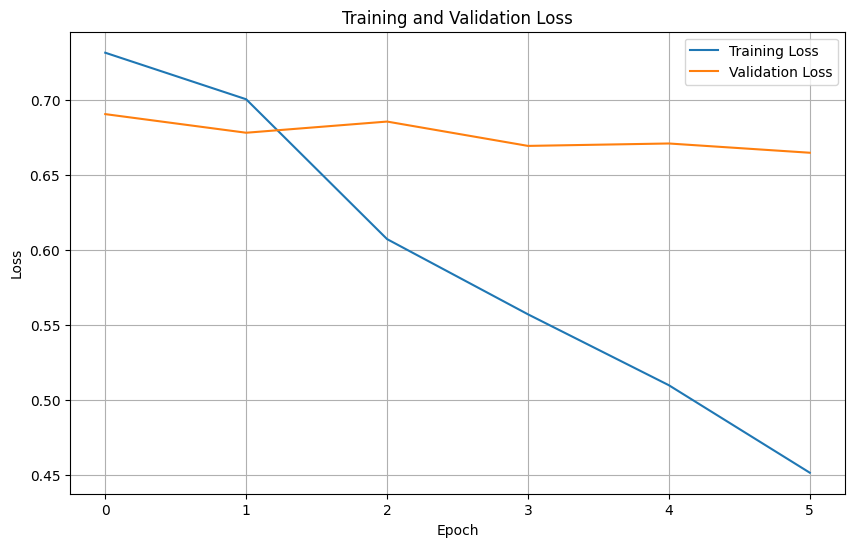

In [29]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_losses3, label='Training Loss')
plt.plot(validation_losses3, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

## 5. Inferencing VGG16 with new and untrained images

In [30]:
# inference_dataset = datasets.ImageFolder(root='Inference_images', transform=transform3)

# inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False)

# vgg16.eval()

# # Perform inference
# with torch.no_grad():  # Disable gradient computation
#     for images, _ in inference_loader:  # Iterate over the DataLoader
#         images = images.to(device)  # Move images to the same device as the model
#         output = vgg16(images)  # Pass the images through the model
        
#         # Get the predicted class index for each image in the batch
#         _, predicted_classes = torch.max(output, 1)
#         print("Predicted class indices:", predicted_classes.cpu().numpy())

In [31]:
transform3 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 5.1 Inferencing Image 18 (Dog)

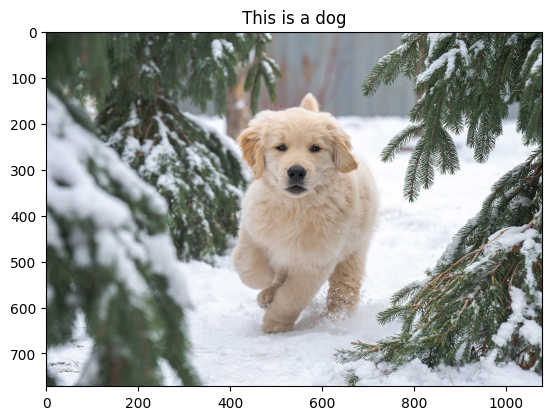

In [33]:
from PIL import Image
from torchvision import transforms

image_path = 'Inference_images/dummy_images/image18.jpg'

image18 = Image.open(image_path)

image_18_transformed = transform3(image18)

image_18_transformed = image_18_transformed.unsqueeze(0)

image_18_transformed = image_18_transformed.to(device)

model.eval()

with torch.no_grad():
    output = vgg16(image_18_transformed)

_, predicted_class = torch.max(output, 1)

if predicted_class.item() == 0:
    plt.title('This is a cat')
    plt.imshow(image18) 
    plt.show()
else:
    plt.title('This is a dog')
    plt.imshow(image18) 
    plt.show()

### 5.2 Inferencing Image 8 (cat)

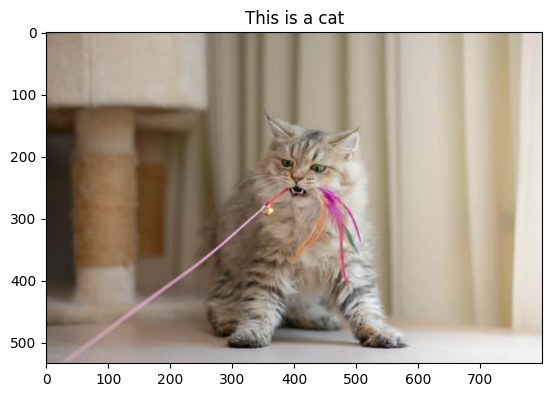

In [34]:
image_path = 'Inference_images/dummy_images/image8.jpg'

image8 = Image.open(image_path)

image_8_transformed = transform3(image8)

image_8_transformed = image_8_transformed.unsqueeze(0)

image_8_transformed = image_8_transformed.to(device)

model.eval()

with torch.no_grad():
    output = vgg16(image_8_transformed)

_, predicted_class = torch.max(output, 1)

if predicted_class.item() == 0:
    plt.title('This is a cat')
    plt.imshow(image8) 
    plt.show()
else:
    plt.title('This is a dog')
    plt.imshow(image8) 
    plt.show()

### 5.3 Inferencing Image 20 (Dog)

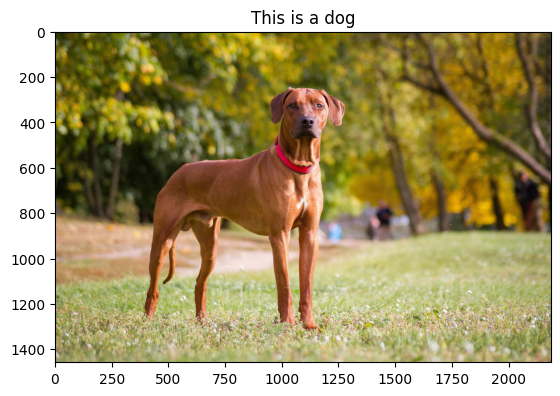

In [35]:
image_path = 'Inference_images/dummy_images/image20.jpg'

image20 = Image.open(image_path)

image_20_transformed = transform3(image20)

image_20_transformed = image_20_transformed.unsqueeze(0)

image_20_transformed = image_20_transformed.to(device)

model.eval()

with torch.no_grad():
    output = vgg16(image_20_transformed)

_, predicted_class = torch.max(output, 1)

if predicted_class.item() == 0:
    plt.title('This is a cat')
    plt.imshow(image20) 
    plt.show()
else:
    plt.title('This is a dog')
    plt.imshow(image20) 
    plt.show()

# 6. Saving all models

In [113]:
#torch.save(vgg16, "VGG16_Model.pth")    # Saving VGG16 Model

In [114]:
#torch.save(model, "NeuralNetwork_Model.pth")    # Saving Neural Network Model

In [115]:
#torch.save(CNNmodel, "CNN_Model.pth")    # Saving CNN Model

In [36]:
# # Load the trained weights
# models.load_state_dict(vgg16)  
# print(type(vgg16))

# Pretrained VGG16 using CPU

In [4]:
from torchvision import transforms
from PIL import Image
from torch import optim


# Pre-processing the images for VGG16
transform4 = transforms.Compose([
    transforms.Resize((224, 224)),          # resizing to 224x224 as per required for VGG16
    transforms.Grayscale(num_output_channels=3),  # converting grayscale to RGB (3 channels)
    transforms.ToTensor(),                 # converting images to pytorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # normalize as per ImageNet
                         std=[0.229, 0.224, 0.225])
])

# Load the datasets
test_dataset4 = datasets.ImageFolder(root='archive-4/test', transform=transform4)
train_dataset4 = datasets.ImageFolder(root='archive-4/train', transform=transform4)

# Create DataLoader objects for batching
train_loader = DataLoader(train_dataset4, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset4, batch_size=16, shuffle=False)

# Print some batch information
data_iter4 = iter(train_loader)
images4, labels4 = next(data_iter4)
print(f"Batch size: {images4.size(0)}")
print(f"Labels: {labels4}")

Batch size: 16
Labels: tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1])


In [5]:

device = "cpu"

# (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )

print(f"Using {device} device")

Using cpu device


In [6]:
from torchvision import models
from torch import nn


# loading pretrained model VGG16
vgg16_2 = models.vgg16(pretrained=True)

# freeze the feature extractor layer
for param in vgg16_2.features.parameters():
    param.requires_grad = False
    

# modifying the classifier to match the dataset (two classes)
num_classes = len(train_dataset4.classes)
vgg16_2.classifier[6] = nn.Linear(4096, num_classes)

# moving the model to the device
vgg16_2 = vgg16_2.to(device)




# # finetuning model according to medium
# vgg16.fc = nn.Sequential(
#     nn.Linear(num_classes, 4096),
#     nn.ReLU(inplace = True),
#     nn.Dropout(0.5),
#     nn.Linear(4096, num_classes)
# )


print(vgg16_2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
from torch import optim

batch_size = 16

# defining the optimizer
optimizer4 = optim.Adam(vgg16_2.classifier[6].parameters(), lr=0.001)

# choosing the loss function
loss_fn4 = nn.CrossEntropyLoss()

# choosing number of epoches
epochs4 = 150

# saving losses for loss line graph
training_losses4 = []
validation_losses4 = []

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)


wandb.init(project="cats-and-dogs-classification-project", name="VGG16_CPU_Run",
          
    config={
    "learning_rate": 0.02,
    "architecture": "VGG16",
    "dataset": "CatsandDogsDataset",
    "epochs": 150,

})

# training the model
for epoch in range(epochs4):
    print(f"Epoch {epoch+1}\n{'_'*20}")
    train_loss4 = train_loop(train_loader, vgg16_2, loss_fn4, optimizer4)
    test_loss4, val_loss4 = test_loop(test_loader, vgg16_2, loss_fn4)
    
    # storing losses
    training_losses4.append(train_loss4)
    validation_losses4.append(test_loss4)
    
    # log metrics to WandB
    
    wandb.log({"epoch2": epochs4,
              "train_loss2": train_loss4,
              "val_loss2":test_loss4,
               "val_accuracy2":val_loss4})
    
    # Early stop check
    early_stopping(val_loss4)
    if early_stopping.early_stop:
        print("Early stop triggered")
        break

        loss_fn = nn.CrossEntropyLoss()
        
wandb.finish()
print("Training completed.")

Epoch 1
____________________
loss: 0.743570 [   16/  557]
loss: 0.476682 [   32/  557]
loss: 0.414569 [   48/  557]
loss: 0.575810 [   64/  557]
loss: 0.179905 [   80/  557]
loss: 0.246107 [   96/  557]
loss: 0.144742 [  112/  557]
loss: 0.300428 [  128/  557]
loss: 0.083417 [  144/  557]
loss: 0.091371 [  160/  557]
loss: 0.127225 [  176/  557]
loss: 0.088524 [  192/  557]
loss: 0.123486 [  208/  557]
loss: 0.226329 [  224/  557]
loss: 0.166006 [  240/  557]
loss: 0.178770 [  256/  557]
loss: 0.144691 [  272/  557]
loss: 0.028298 [  288/  557]
loss: 0.151268 [  304/  557]
loss: 0.181860 [  320/  557]
loss: 0.181300 [  336/  557]
loss: 0.077342 [  352/  557]
loss: 0.134471 [  368/  557]
loss: 0.034993 [  384/  557]
loss: 0.433787 [  400/  557]
loss: 0.009673 [  416/  557]
loss: 0.146494 [  432/  557]
loss: 0.007502 [  448/  557]
loss: 0.006666 [  464/  557]
loss: 0.111334 [  480/  557]
loss: 0.149117 [  496/  557]
loss: 0.086662 [  512/  557]
loss: 0.142889 [  528/  557]
loss: 0.015791

epoch2,▁▁▁▁▁▁
train_loss2,█▃▂▂▁▁
val_accuracy2,▁▄▅▇█▇
val_loss2,█▆▇▄▃▁
epoch2,150
train_loss2,0.01721
val_accuracy2,97.85714
val_loss2,0.05162


Training completed.


In [12]:
torch.save(vgg16_2, "VGG16_CPU.pth")